# GD10. 프로젝트 : 개선된 U-Net 모델 만들기 (U-Net++)

## 1. Intro
- U-Net을 통한 시맨틱 세그멘테이션은 어느 정도 동작하는 것 같긴 하지만 더 개선할 여지도 보임. 
- 2018년에 U-Net++라는 논문이 나옴. 아주 단순하면서도 세그멘테이션에서 효과를 발휘했던 U-Net의 네트워크 구조에 DenseNet의 아이디어를 가미해 성능을 개선한 모델임. 논문은 2020년에 한 번 업그레이드됨. 
- U-Net++ 모델을 구현해보고, U-Net을 활용했던 도로 세그멘테이션 태스크에 적용해 U-Net을 썼을 때보다 성능이 향상되었음을 확인해보자. 
- 정성적으로는 두 모델의 세그멘테이션의 결과를 시각화해서 비교하고, 정량적으로는 동일 이미지에 대한 IoU 값을 비교해보자.   
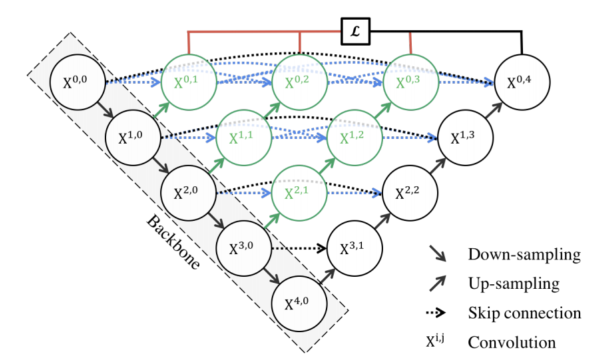

## 2. 시맨틱 세그멘테이션 데이터셋

### 이미지, 데이터 가져오기
- 시맨틱 세그멘테이션으로 도로의 영역을 분리하기 위해서는 도로의 영역을 라벨로 가진 데이터셋을 가지고 학습할 수 있도록 파싱해야 함.
- 아래 링크로 object detection으로 사용했던 KITTI 데이터셋의 세그멘테이션 데이터를 다운로드함.
- 데이터 출처 : http://www.cvlibs.net/datasets/kitti/eval_semantics.php

### 데이터 로더 만들기
- 이미지와 데이터셋이 주어졌으니 모델을 학습시킬 수 있는 데이터 로더를 만들어보자.
- 로더는 입력값 (224, 224), 출력값 (224, 224) 크기를 갖는 모델을 학습시킬 수 있도록 데이터셋을 파싱해야 함.
- 이 때 데이터 로더에 augmentation을 적용해보자 -> albumentations 사용

In [1]:
# 필요한 라이브러리를 로드
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from keras import regularizers

- Albumentation의 사용법을 간단히 알아보자.
- 아래는 다양한 augmentation 기법을 확률적으로 적용할 수 있게 해주는 Compose()의 활용 예임.
- imgaug의 Sometimes()와 유사한 기능임.

In [2]:
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터일 경우
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터일 경우에는 224X224로 resize만 수행
                Resize(
                    width=224,
                    height=224
                    )
                ])

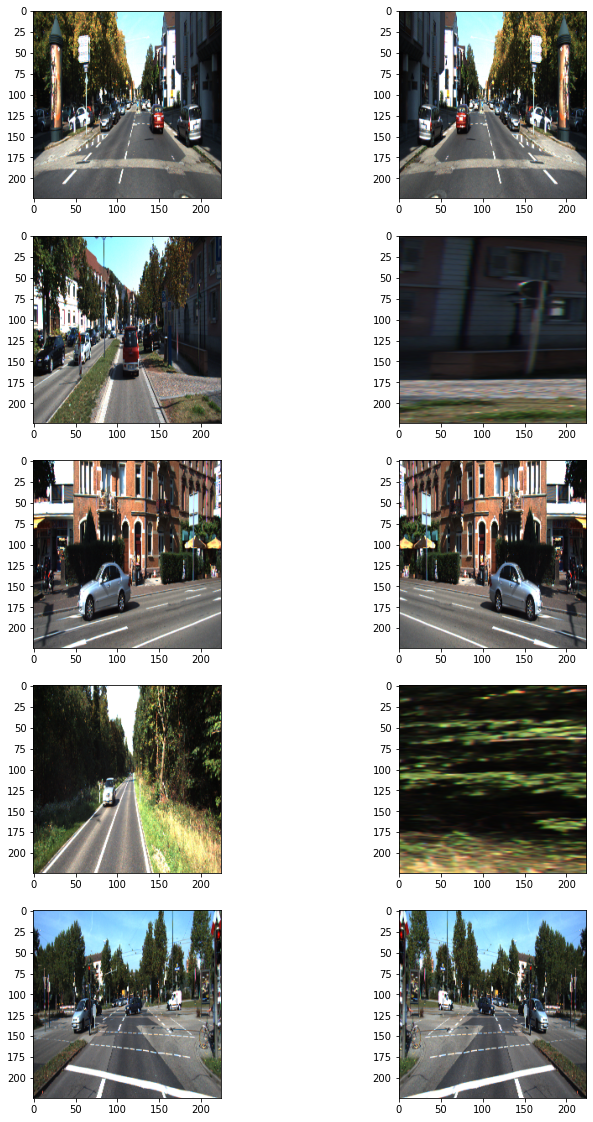

In [3]:
dir_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL/Going Deeper/GD10/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋에서 5개만 가져와 augmentation을 적용 
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

- 이제 데이터셋을 구성해보자.
- tf.keras.utils.Sequence를 상속받은 generator 형태로 데이터를 구성해보자.

In [4]:
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받음.
  우리가 KittiDataset을 원하는 방식으로 preprocess하기 위해서 Sequnce를 커스텀해 사용함.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path
    batch_size: batch_size
    img_size: preprocess에 사용할 입력 이미지의 크기
    output_size: ground_truth를 만들어주기 위한 크기
    is_train: 이 Generator가 학습용인지 테스트용인지 구분
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받음
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지를 확인
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수
    # 이때 is_train에 따라 test set을 분리해서 load하도록 해야함.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력을 만듦.
    # 입력은 resize및 augmentation이 적용된 input image이고 
    # 출력은 semantic label임.
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수. 학습 중인 경우에 순서를 random shuffle하도록 적용함.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [5]:
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## 3. 시맨틱 세그멘테이션 모델

### 기존 모델 구조 (U-Net)

In [6]:
def build_unet(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)
	
  # Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  # Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

In [7]:
model_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL/Going Deeper/GD10/seg_model_unet.h5'

model = build_unet()
model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model.save(model_path)  # 학습한 모델을 저장

Epoch 1/100
11/11 [==============================] - 18s 389ms/step - loss: 0.6820 - val_loss: 0.6683
Epoch 2/100
11/11 [==============================] - 4s 326ms/step - loss: 0.6183 - val_loss: 0.4437
Epoch 3/100
11/11 [==============================] - 4s 326ms/step - loss: 0.1650 - val_loss: 0.0294
Epoch 4/100
11/11 [==============================] - 4s 328ms/step - loss: 0.0364 - val_loss: 0.0380
Epoch 5/100
11/11 [==============================] - 4s 327ms/step - loss: 0.0299 - val_loss: 0.0363
Epoch 6/100
11/11 [==============================] - 4s 326ms/step - loss: 0.0245 - val_loss: 0.0285
Epoch 7/100
11/11 [==============================] - 4s 327ms/step - loss: 0.0241 - val_loss: 0.0377
Epoch 8/100
11/11 [==============================] - 4s 334ms/step - loss: 0.0233 - val_loss: 0.0291
Epoch 9/100
11/11 [==============================] - 4s 328ms/step - loss: 0.0333 - val_loss: 0.0360
Epoch 10/100
11/11 [==============================] - 4s 326ms/step - loss: 0.0412 - val_l

### 개선된 모델 구조 (U-Net++)

In [8]:
def build_unetplusplus(input_shape=(224, 224, 3), num_class=1, deep_supervision=False, batch_size=8):
    inputs = Input(input_shape)
    
    conv1_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1_1)
    conv2_1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2_1)
    conv3_1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3_1)
    conv4_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    conv5_1 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)
    pool5 = MaxPooling2D(pool_size=(2, 2))(conv5_1)

    up1_2 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_1)
    conv1_2 = concatenate([up1_2, conv1_1], axis = 3)
    conv1_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_2)
    up2_2 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv3_1)
    conv2_2 = concatenate([up2_2, conv2_1], axis = 3)
    conv2_2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_2) 
    up3_2 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv4_1)
    conv3_2 = concatenate([up3_2, conv3_1], axis = 3)
    conv3_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3_2)
    up4_2 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv5_1)
    conv4_2 = concatenate([up4_2, conv4_1], axis = 3)
    conv4_2 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4_2)

    up1_3 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_2)
    conv1_3 = concatenate([up1_3, conv1_1, conv1_2], axis = 3)
    conv1_3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_3)
    up2_3 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv3_2)
    conv2_3 = concatenate([up2_3, conv2_1, conv2_2], axis = 3)
    conv2_3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_3)
    up3_3 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv4_2)
    conv3_3 = concatenate([up3_3, conv3_1, conv3_2], axis = 3)
    conv3_3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3_3)
    
    up1_4 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv2_3)
    conv1_4 = concatenate([up1_4, conv1_1, conv1_2, conv1_3], axis = 3)
    conv1_4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_4)
    up2_4 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv3_3))
    conv2_4 = concatenate([up2_4, conv2_1, conv2_2, conv2_3], axis = 3)
    conv2_4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2_4)

    up1_5 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2))(conv2_4))
    conv1_5 = concatenate([up1_5, conv1_1, conv1_2, conv1_3, conv1_4], axis = 3)
    conv1_5 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1_5)
 
    nestnet_output_1 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_1', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1_2)
    nestnet_output_2 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_2', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1_3)
    nestnet_output_3 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_3', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1_4)
    nestnet_output_4 = Conv2D(num_class, (1, 1), activation='sigmoid', name='output_4', kernel_initializer = 'he_normal', padding='same', kernel_regularizer=regularizers.l2(1e-4))(conv1_5)

    if deep_supervision:
        model = Model(inputs=inputs, outputs=[nestnet_output_1,
                                               nestnet_output_2,
                                               nestnet_output_3,
                                               nestnet_output_4])
    else:
        model = Model(inputs=inputs, outputs=[nestnet_output_4])

    return model

In [9]:
model_unetplusplus = build_unetplusplus()
model_unetplusplus.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_20 (Conv2D)             (None, 224, 224, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_4 (MaxPooling2D)  (None, 112, 112, 64  0          ['conv2d_20[0][0]']              
                                )                                                           

In [10]:
# deep_supervision
model_unetplusplusds = build_unetplusplus(deep_supervision=True)
model_unetplusplusds.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_37 (Conv2D)             (None, 224, 224, 64  1792        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d_9 (MaxPooling2D)  (None, 112, 112, 64  0          ['conv2d_37[0][0]']              
                                )                                                           

In [11]:
model_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL/Going Deeper/GD10/seg_model_unetplusplus.h5'

opt = tf.keras.optimizers.Adam(1e-4)
model_unetplusplus.compile(optimizer = opt, loss = 'binary_crossentropy')
model_unetplusplus.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

model_unetplusplus.save(model_path)

Epoch 1/100
11/11 [==============================] - 13s 713ms/step - loss: 0.6785 - val_loss: 0.6514
Epoch 2/100
11/11 [==============================] - 7s 652ms/step - loss: 0.5749 - val_loss: 0.4125
Epoch 3/100
11/11 [==============================] - 7s 653ms/step - loss: 0.1154 - val_loss: 0.0364
Epoch 4/100
11/11 [==============================] - 7s 652ms/step - loss: 0.0347 - val_loss: 0.0374
Epoch 5/100
11/11 [==============================] - 7s 652ms/step - loss: 0.0352 - val_loss: 0.0302
Epoch 6/100
11/11 [==============================] - 7s 651ms/step - loss: 0.0308 - val_loss: 0.0264
Epoch 7/100
11/11 [==============================] - 7s 652ms/step - loss: 0.0277 - val_loss: 0.0299
Epoch 8/100
11/11 [==============================] - 7s 652ms/step - loss: 0.0272 - val_loss: 0.0344
Epoch 9/100
11/11 [==============================] - 7s 652ms/step - loss: 0.0312 - val_loss: 0.0271
Epoch 10/100
11/11 [==============================] - 7s 653ms/step - loss: 0.0291 - val_l

## 4. 시맨틱 세그멘테이션 모델 시각화
- 학습한 모델의 결과를 눈으로 확인해보자.
- 앞에서 저장한 모델이나 제공된 모델을 아래 코드로 불러오자.
- 테스트 셋은 이미지를 제공하지만 정답 데이터를 제공하지 않기에 눈으로 확인할 수 있도록 모델이 inference한 결과를 우리의 눈으로 볼 수 있는 세그멘테이션 이미지로 만들자.
- 이 때 입력 이미지와 라벨을 한 번에 볼 수 있도록 모델의 출력값을 입력 이미지 위에 겹쳐서 보이기, 즉 오버레이하자. PIL 패키지를 사용한다면 `Image.blend`를 활용할 수 있음.

In [12]:
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라짐
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output

- 세그멘테이션의 성능을 정량적으로 측정하기 위한 방법으로 IoU를 계산함. 모델이 도로 영역이라고 판단한 부분이 1로, 나머지 부분이 0으로 표시된 행렬, 그리고 라벨 데이터에서 도로 영역이 1, 나머지 부분이 0으로 표시된 행렬이 필요함. 각각을 prediction, target이라고 불렀을 때 이를 계산하는 함수를 구현하자.
- 위에 구현했던 get_output을 좀 더 확장해 output, prediction, target을 함께 리턴하도록 구현.

In [13]:
def calculate_iou_score(target, prediction):
  intersection = np.logical_and(target, prediction)
  union = np.logical_or(target, prediction)
  iou_score = float(np.sum(intersection)) / float(np.sum(union))
  print('IoU : %f' % iou_score)
  return iou_score

In [14]:
def get_output_iou(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  # 0.5라는 threshold를 변경하면 도로인식 결과범위가 달라짐
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화!
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _

### U-Net

In [15]:
unet_model_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL/Going Deeper/GD10/seg_model_unet.h5'
unet_model = tf.keras.models.load_model(unet_model_path)

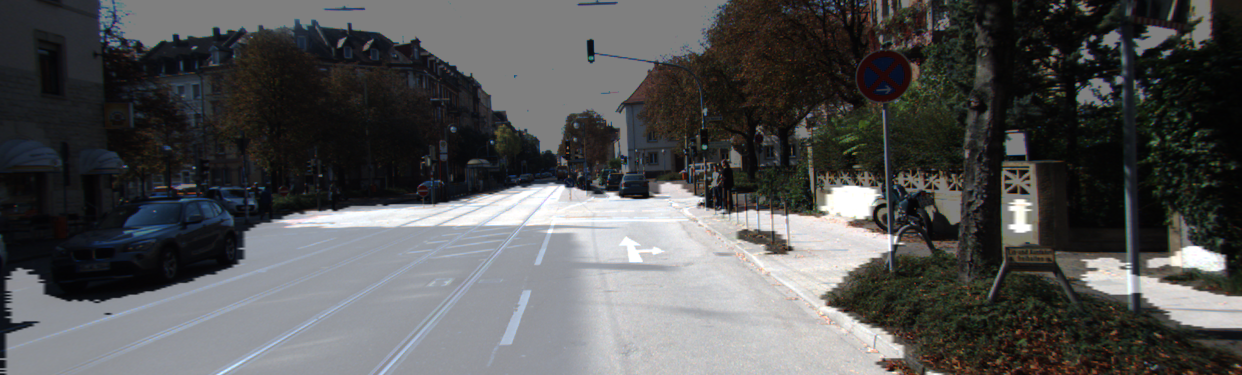

In [16]:
i = 1    # i값을 바꾸면 테스트용 파일이 변경됨
get_output(
     unet_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [17]:
output, prediction, target = get_output_iou(
     unet_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.815167


0.8151674545575605

### U-Net++

In [18]:
unetplusplus_model_path = '/content/drive/MyDrive/Colab Notebooks/AIFFEL/Going Deeper/GD10/seg_model_unetplusplus.h5'
unetplusplus_model = tf.keras.models.load_model(unetplusplus_model_path)

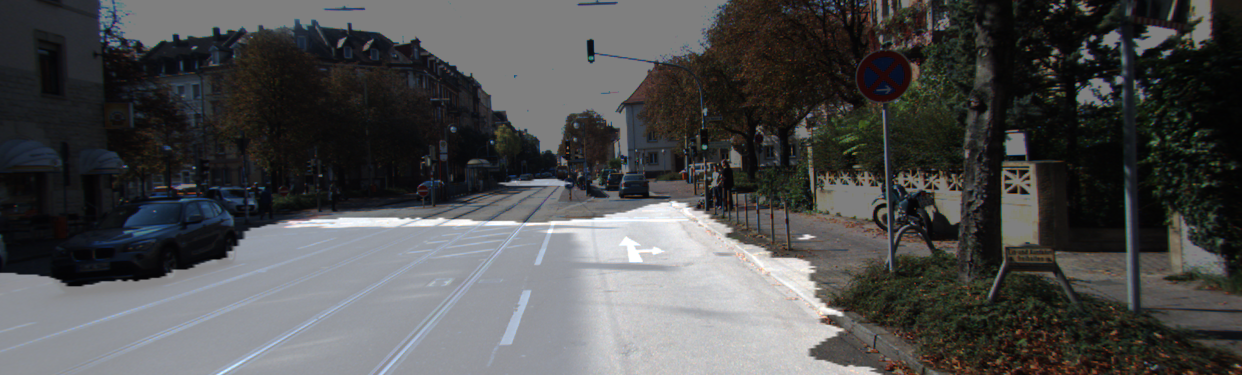

In [19]:
i = 1
get_output(
     unetplusplus_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [20]:
output, prediction, target = get_output_iou(
     unetplusplus_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

IoU : 0.886651


0.8866510183993337